# Build Your Own Transformer-Based LLM From Scratch 

This jupyter notebook contains a miniature implementation of the famous ["Attention Is All You Need" paper](https://arxiv.org/pdf/1706.03762)'s transformer architecture with layers/components built from scratch using PyTorch. This architecture is what started the snowball of high performance LLMs in the recent years, including the GPT models!

This tutorial is based off of the following video that goes into a lot more depth into technicalities: https://www.youtube.com/watch?v=kCc8FmEb1nY. 

### Install PyTorch

In [42]:
!pip install torch==2.3.1

### Import PyTorch & Required Tools

In [43]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# set random seed for reproducible results 
torch.manual_seed(1337)

### Download and observe the training data
Note the destination directory that the data is being downloaded into! 
#### We'll be using a small Shakespeare dataset.

In [44]:
!curl https://raw.githubusercontent.com/karpathy/ng-video-lecture/refs/heads/master/input.txt -o input_data

with open('input_data', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in chars:", len(text))
print("first thousand chars: \n", text[:1000])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  2683k      0 --:--:-- --:--:-- --:--:-- 2682k
length of dataset in chars: 1115394
first thousand chars: 
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think 

### Build the Tokenizer 

In [45]:
# get all unique characters
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print(vocab_size)

# create tokenizer fpr the input text by characters
str2int = { ch:i for i,ch in enumerate(vocab)}
int2str = { i:ch for i,ch in enumerate(vocab)}
encoder = lambda s: [str2int[c] for c in s] # given string, return list of ints 
decorder = lambda l: ''.join([int2str[i] for i in l]) # given list, return string


65


### Encode text and prepare test-train split

In [60]:
# encode input dataset and place it in tensor 
data = torch.tensor(encoder(text), dtype=torch.long)

# train validation split 
n = int(.9*len(data))
train_data = data[:n]
val_data = data[n:]
print(train_data)

tensor([18, 47, 56,  ..., 43, 56, 43])


## Lets Start Building the Model


### Feed Forward Block
A feed forward block is a simple neural network layer that consists of two linear transformations, one after the other. This feed forward block contains a ReLU between the two linear layers. The ReLU function, or Rectified Linear Unit, is a mathematical function that returns the input if it is positive, and 0 if it is negative. It is commonly used as an activation function in neural networks.

In [47]:
class FeedForward(nn.Module):
    """ simple linear layer followed by non-linearity """

    def __init__(self, n_embed, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_embed * 4), # scale computation by 4
            nn.ReLU(), 
            nn.Linear(n_embed * 4, n_embed), # scale residual computation by 4
            nn.Dropout(dropout)
        )

    def forward(self, x):
        output = self.net(x)
        return output

### Attention Head & Multi-Head Attention Block
**Attention Head**: An attention head is a sub-component of a multi-head attention block. It takes a query vector, a set of key-value pairs, and outputs a weighted sum of the values based on the similarity between the query and the keys.
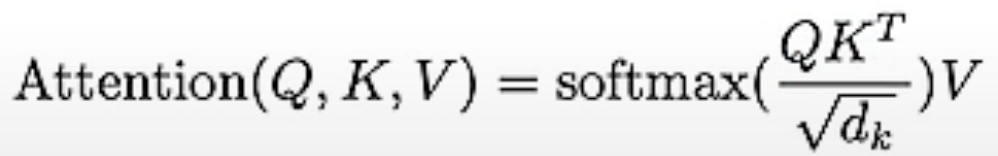
**Multi-Head Attention Block**: A multi-head attention block is a neural network layer that consists of multiple attention heads. It takes a query vector, a set of key-value pairs, and outputs a weighted sum of the values based on the similarity between the query and the keys. The output of the multi-head attention block is then passed through a feed forward block.



In [48]:
class Head(nn.Module):

    """ single head of self-attention """

    def __init__(self, n_embed, head_size, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', tensor=torch.tril(torch.ones(block_size, block_size))) # adding as a constant parameter
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        B,T,C = x.shape

        # each block on input independently produce a key and a query
        # Key: output is what tokens does x contain
        k = self.key(x) # B,T,C
        # Query: output is what tokens is x looking for
        q = self.query(x) # B,T,C

        # dot product of q and k: compute the affinities i.e. the attention scores: some tokens will find other tokens more or less interesting
        wei = q @ k.transpose(-2, -1) * C**-0.5 # B,T,C multiplied by B, C, T produces B, T, T
        # triangular mask means we only pay attention to previous tokens
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # B, T, T
        # softmax 
        wei = F.softmax(wei, dim=-1) # size is B,T,T
        wei = self.dropout(wei)
        # perform weighted aggregation of values
        v = self.value(x) # B,T,C
        weighted_aggregation = wei @ v # B,T,T multiplied by B,T,C produces B,T,C

        return weighted_aggregation

class MultiHeadAttention(nn.Module):

    """ multiple heads of self attention in parallel """

    def __init__(self, n_heads, block_size, head_size, dropout, n_embed):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embed, head_size, block_size, dropout) for _ in range(n_heads)])
        self.projection = nn.Linear(n_heads * head_size, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        output = torch.cat([h(x) for h in self.heads], dim=-1)
        output = self.dropout(self.projection(output))
        return output

### Transformer Block

A transformer block is a neural network layer that consists of a multi-head attention block and a feed forward block. It takes a query vector, a set of key-value pairs, and outputs a weighted sum of the values based on the similarity between the query and the keys. The output of the transformer block is then passed through a feed forward block.

In [49]:
class TransformerBlock(nn.Module):

    """ transformer block: communication followed by computation """

    def __init__(self, n_embed, n_heads, block_size, dropout):
        super().__init__()
        head_size = n_embed // n_heads
        self.sa = MultiHeadAttention(n_heads, block_size, head_size, dropout, n_embed)
        self.ffwd = FeedForward(n_embed, dropout)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


### Putting it all together!
A BigramLanguageModel is a type of language model that predicts the next word in a sentence based on the previous **two words**, hence the prefix (Bi-). We will build it using the blocks we previously defined. 

In [50]:
# Model Hyperparameters 
block_size = 128 # maximum context length for prediction
n_embed = 142 # number of embedding dimensions 
n_heads = 4
n_layers = 6
dropout = 0.2
vocab_size = 65


class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed) # this will allow us to encode the meaning of the tokens 
        self.position_embedding_table = nn.Embedding(block_size, n_embed) # this will allow us to encode the position of the tokens
        self.blocks = nn.Sequential(*[TransformerBlock(n_embed, n_heads, block_size, dropout) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(n_embed) # finaly layer normalization 
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        token_embeddings = self.token_embedding_table(idx) # (B,T,C)
        position_embedding = self.position_embedding_table(torch.arange(T)) # (T, C)
        x = token_embeddings + position_embedding # (B,T,C)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None: # in the case where we are running inference
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # convert array to 2Dtr
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, target=targets)

        return logits, loss
    

    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices for the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens 
            idx_cond = idx[:, -block_size:]
            # get predictions
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # get last time step, (B,C)
            probs = F.softmax(logits, dim=1) # get probability 
            next_idx = torch.multinomial(probs, num_samples=1) # (B,1)
            idx = torch.cat((idx, next_idx), dim=1) # (B, T+1)
        return idx

#### Let's see how the model performs prior to training

In [58]:
m = BigramLanguageModel()
print(decorder(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


tgRVxeeoJKVchAPRB,$pX!B;wIsUJqKMD.fIYwqlwT.zZh-.!A wyoFMPC&ifW.wXWwAAj3H;ItqA3WusQPmbMsqQpIWkyUT'k.R


The result is a bunch of completely random tokens from our vocab. This is expected as the model is initialized to random parameters. 

## Lets train the model!

In [41]:
# define training hyperparameters
batch_size = 4 # number of independent sequences processed in parallel
max_iterations = 5000
learning_rate = 3e-4
eval_interval = 1000
eval_iters = 200


# initialize the model we created
model = BigramLanguageModel()

# define a function that generates batches of data for training or validation. 
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,)) # generate $batch_size number of random indexes
    x = torch.stack([data[i:i+block_size] for i in ix]) # batch chunks for each random index 
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # offset by 1 for next char prediction
    return x, y

@torch.no_grad() #setting to no back propagation! more efficient memory mode


# define function to calculate the mean loss for the model during training and testing 
def estimate_loss():
    out = {}
    model.eval # switch to eval mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # switch back to train mode
    return out 
xb, yb = get_batch('train')


# get pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# training loop
for iter in range(max_iterations):

    # evaluate loss on training and validation data every few iterations 
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"Training loss at step {iter}: {losses['train']:.4f} \nValidation loss at step {iter}: {losses['val']:.4f}")

    # sample a batch
    xb, yb = get_batch('train')

    # evaluate loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Training loss at step 0: 4.3404 
Validation loss at step 0: 4.3501
Training loss at step 1000: 2.4414 
Validation loss at step 1000: 2.4643
Training loss at step 2000: 2.2943 
Validation loss at step 2000: 2.3042
Training loss at step 3000: 2.1522 
Validation loss at step 3000: 2.2031
Training loss at step 4000: 2.0412 
Validation loss at step 4000: 2.1139


### Sample generation!

Let's see how the model performs post training

In [59]:
print(decorder(model.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))



Whaly prase, agesif! Ines:
You wall, knoway your prave lomy me.

LOENCENTER:
Tholk 'This an delfs!

ANGHAH:
Thes, as INould haple dam the kinking theing
You shiche shall to his intesatool's lordcy gonge!

MERCUans, Yorkize, What othr lous I Hey,'d were lancalt it
If he reguan, larnd a ongenow: not Lord giefuld:
On nir sigisent
En Ravent on my pruc des,
Foor bage'd booth of ther of berpoble.
Dey! fay!
To cousis, and tur hee she spirthe hat dank
Noble of infur the pludmy dease nedt sugee gring;
An



Given our hardware and time restrictions its not great. The larger you make the model's hyperparameters (especially n_embed, which is the number of embeddings we capture), the more likely it is to perform better, but the longer it'll take to train due to the increase in the number of model weights to be computed/optimized. 